## Imports

In [1]:
%pylab inline
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
from statsmodels.tsa.arima_model import ARIMA

## Data loading & cleaning

In [3]:
from helper import clean_data
from helper import vix_prime_combine

In [4]:
pct, vix_close , prime, weekly_vix, monthly_vix = clean_data()

In [5]:
vp_df = vix_prime_combine(monthly_vix,prime) ## combines monthly vix data & monthly prime data

## Look for stationarity of my data with Dicker Fuller test

In [6]:
import statsmodels.tsa.stattools as ts
from helper import dftest

Test Statistic            -5.508621
p-value                    0.000002
Lags Used                 11.000000
Observations Used       7305.000000
Critical Value (1%)       -3.431245
Critical Value (5%)       -2.861936
Critical Value (10%)      -2.566981
dtype: float64


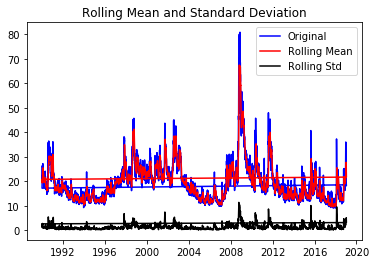

In [7]:
dftest(vix_close.vix_close)

It passed! According to Jonathan I can still try differencing.

## Let's split data up into test and train

In [8]:
from helper import split_data

In [9]:
train, validation, test = split_data(weekly_vix,52)

## Now let's try an AR models

First let's optimize p. I stopped at 15 because it got too slow.

In [10]:
from helper import optimize_ar
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA

In [11]:
a = ARIMA(train.vix_close,order=(2,1,0)).fit()
a.aic

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

5698.5635789314565

In [12]:
validation['preds'] = a.predict(weekly_vix.shape[0]-52*4, weekly_vix.shape[0]-52*2, dynamic=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


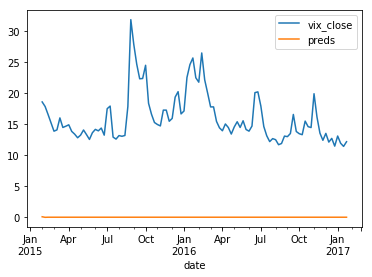

In [14]:
validation[['vix_close','preds']].plot()

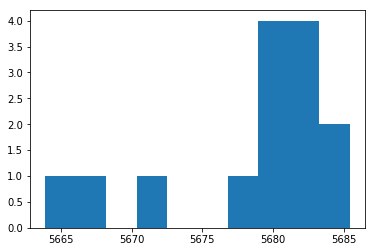

In [15]:
train_ar_params = optimize_ar(train, 15)

In [16]:
train_ar_params

(5663.911857997156, 14)

Best AIC for AR is 5663 at p=14

## Now let's try an AR models with differencing (ARI?)

In [17]:
model = ARIMA(train, order=(14,1,0))
model_fit = model.fit()
model_fit.aic

5672.8036540651765

In [18]:
model = ARIMA(train, order=(14,2,0))
model_fit = model.fit()
model_fit.aic

5785.429334069058

Model is worse with d at 1 or 2!

## Now let's try an ARIMA model

This function doesn't complete in 5 minutes with my p at 14 and since my difference between p 14 and p 1 was only 20 points out of 6k for AIC I'm going to simplify to p = 1

In [19]:
#I'm making p smaller to decrease compute time
aic_res_arima = []
for i in range(1,5):
    model = ARIMA(train, order=(1,0,i))
    model_fit = model.fit()
    #print(i, model_fit.aic)
    aic_res_arima.append(model_fit.aic)

In [20]:
np.array(aic_res_arima).argmin()

0

In [21]:
aic_res_arima

[5681.04385159504, 5682.306080164076, 5682.81581270908, 5683.967103889868]

MA also don't help, keep Q=0

Seems like my best model is (p,d,q) = (1,0,0) so far with an AIC of 5679.

## Let's try predicting things

In [24]:
validation['preds'] = a.predict(weekly_vix.shape[0]-52*4, weekly_vix.shape[0]-52*2, dynamic=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Those are some bad predictions! I'm going to look at RMSE as well.

## Reoptimize with RMSE as scoring param

In [27]:
from helper import RMSE
from helper import optimize_ar_rmse

In [28]:
optimize_ar_rmse(train,validation,weekly_vix,4)

/Users/nmp256/Code/datascience/metis/luther/helper.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  val['preds'] = model_fit.predict(tot.shape[0]-52*4, tot.shape[0]-52*2, dynamic=False)


([            vix_close      preds
  date                            
  2015-02-01    18.5820  18.075703
  2015-02-08    17.8460  18.074458
  2015-02-15    16.5540  18.145923
  2015-02-22    15.2100  18.211623
  2015-03-01    13.8680  18.276500
  2015-03-08    14.0740  18.338784
  2015-03-15    16.0080  18.398689
  2015-03-22    14.4660  18.456264
  2015-03-29    14.6680  18.511604
  2015-04-05    14.8950  18.564793
  2015-04-12    13.8340  18.615916
  2015-04-19    13.3880  18.665053
  2015-04-26    12.8060  18.712281
  2015-05-03    13.2340  18.757674
  2015-05-10    14.0600  18.801303
  2015-05-17    13.3180  18.843238
  2015-05-24    12.5400  18.883543
  2015-05-31    13.6200  18.922282
  2015-06-07    14.1580  18.959516
  2015-06-14    13.9220  18.995304
  2015-06-21    14.3700  19.029701
  2015-06-28    13.2280  19.062761
  2015-07-05    17.4900  19.094538
  2015-07-12    17.9120  19.125079
  2015-07-19    12.9120  19.154434
  2015-07-26    12.5940  19.182649
  2015-08-02    13.1

In [29]:
from helper import plot_preds

/Users/nmp256/Code/datascience/metis/luther/helper.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  val['preds'] = model_fit.predict(tot.shape[0]-52*4, tot.shape[0]-52*2, dynamic=False)


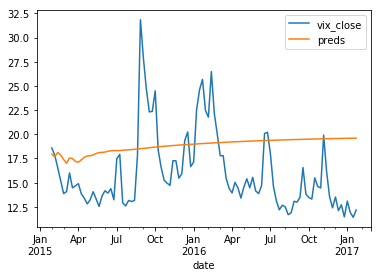

In [30]:
plot_preds(train,validation,weekly_vix)

## SARIMA test

In [31]:
import statsmodels.api as sm

In [33]:
sar = sm.tsa.statespace.SARIMAX(train, order=(1,0,0), seasonal_order=(0,0,0,12), trend='c').fit()
sar.aic

5679.055033917551

In [34]:
pred = sar.get_prediction(weekly_vix.shape[0]-52*4,weekly_vix.shape[0]-52*2)

In [35]:
validation['preds'] = pred.predicted_mean

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
RMSE(validation.vix_close.values,validation.preds.values)

5.213457986082366

In [37]:
from helper import MAPE

In [38]:
MAPE(validation.vix_close.values,validation.preds.values)

32.096528434969244

In [ ]:
#MAPE(p_validation.y.values,p_validation.preds.values)

In [ ]:
validation[['vix_close','preds']].plot()

I haven't tuned this but I'm not super confident it'll get better.

## Include Exogenous variables (SARIMAX)

In [ ]:
train, validation, test = split_data(vp_df,12)
#I go for monthly data here as my prime rate is only per month

In [ ]:
sar = sm.tsa.statespace.SARIMAX(train['vix_close'], order=(5,2,0), seasonal_order=(0,0,0,12), trend='c').fit()

In [ ]:
sar.aic

Wow, way better AIC on the monthly data!

In [ ]:
sar = sm.tsa.statespace.SARIMAX(train['vix_close'],exog=train['prime_rate'], order=(5,2,0), seasonal_order=(0,0,0,12), trend='c').fit()

In [ ]:
sar.aic

About the same with prime rate as exogenous data

In [ ]:
exog_forecast = validation.loc[:,['prime_rate']]

In [ ]:
pred = sar.get_prediction(vp_df.shape[0]-12*4,vp_df.shape[0]-12*2-1,exog=exog_forecast)

In [ ]:
validation['preds'] = pred.predicted_mean

In [ ]:
RMSE(validation.vix_close.values,validation.preds.values)

In [ ]:
validation[['vix_close','preds']].plot()

RMSE got way worse and graph looks terrible

So far nothing too satisfying, but it all is working. I move on to the Luther Prophet Notebook next to examine the Prophet model from Facebook